Deep Learning
=============


The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    saved = pickle.load(f)
    for key, item in saved.items():
        exec(key+'=item')
    del saved  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape([-1, image_size * image_size]).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels)==labels[:,np.newaxis]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
              / predictions.shape[0])


## L2 regularization


Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### 1 Logistic regression

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    lam    = tf.placeholder(tf.float32)
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            lam*tf.nn.l2_loss(weights)
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
            tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

batch_accuracy = []
valid_accuracy = []
test_accuracy  = []
lams = np.arange(0,0.005,0.0005,dtype=np.float32)

with tf.Session(graph=graph) as session:
    for lam0 in lams:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lam : lam0}
            _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            #    print("Minibatch loss at step %d: %f" % (step, l))
            #    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #    print("Validation accuracy: %.1f%%" % accuracy(
            #        valid_prediction.eval(), valid_labels))
        batch_accuracy.append(accuracy(predictions,batch_labels))
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
        print('Lambda = ',lam0)


Lambda =  0.0
Lambda =  0.0005
Lambda =  0.001
Lambda =  0.0015
Lambda =  0.002
Lambda =  0.0025
Lambda =  0.003
Lambda =  0.0035
Lambda =  0.004
Lambda =  0.0045


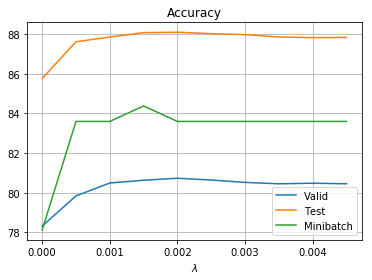

In [7]:
plt.plot(lams,valid_accuracy,label='Valid')
plt.plot(lams,test_accuracy,label='Test')
plt.plot(lams,batch_accuracy,label='Minibatch')
plt.xlabel('$\lambda$')
plt.legend()
plt.grid()
plt.title('Accuracy');

---
### Neural Network

In [8]:
batch_size = 128
num_hidden = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_hidden]))
    biases  = tf.Variable(tf.zeros([num_hidden]))
  
    weights_hidden = tf.Variable(
            tf.truncated_normal([num_hidden, num_labels]))
    biases_hidden  = tf.Variable(tf.zeros([num_labels]))
    lam    = tf.placeholder(tf.float32)

    # Training computation.
    z      = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    logits = tf.matmul(z, weights_hidden) + biases_hidden
    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            lam*(tf.nn.l2_loss(weights)+tf.nn.l2_loss(weights_hidden))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    z=tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    valid_prediction = tf.nn.softmax(tf.matmul(z,weights_hidden)+biases_hidden)
    
    z=tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(z, weights_hidden) + biases_hidden)

In [9]:
num_steps = 3001

valid_accuracy = []
test_accuracy  = []
batch_accuracy = []
lams = np.arange(0,0.005,0.0005,dtype=np.float32)

with tf.Session(graph=graph) as session:
    for lam0 in lams:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lam : lam0}
            _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            #    print("Minibatch loss at step %d: %f" % (step, l))
            #    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #    print("Validation accuracy: %.1f%%" % accuracy(
            #        valid_prediction.eval(), valid_labels))
        batch_accuracy.append(accuracy(predictions,batch_labels))
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
        print('Lambda = ',lam0)

Lambda =  0.0
Lambda =  0.0005
Lambda =  0.001
Lambda =  0.0015
Lambda =  0.002
Lambda =  0.0025
Lambda =  0.003
Lambda =  0.0035
Lambda =  0.004
Lambda =  0.0045


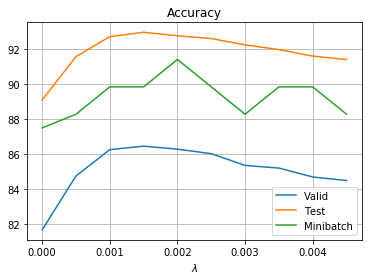

In [10]:
plt.plot(lams,valid_accuracy,label='Valid')
plt.plot(lams,test_accuracy,label='Test')
plt.plot(lams,batch_accuracy,label='Minibatch')
plt.xlabel('$\lambda$')
plt.legend()
plt.grid()
plt.title('Accuracy');

---
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.



In [54]:
batch_size = 128
num_hidden = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    lam    = tf.constant(0.0015)
  
    # Variables.
    weights = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_hidden]))
    biases  = tf.Variable(tf.zeros([num_hidden]))
  
    weights_hidden = tf.Variable(
            tf.truncated_normal([num_hidden, num_labels]))
    biases_hidden  = tf.Variable(tf.zeros([num_labels]))
    prob = tf.placeholder(tf.float32)

    # Training computation.
    z      = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases),prob)
    logits = tf.matmul(z, weights_hidden) + biases_hidden
    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            lam*(tf.nn.l2_loss(weights)+tf.nn.l2_loss(weights_hidden))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    z=tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    valid_prediction = tf.nn.softmax(tf.matmul(z,weights_hidden)+biases_hidden)
    
    z=tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(z, weights_hidden) + biases_hidden)

In [58]:
num_steps = 3001

with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, prob : 1.0}
            _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            #    print("Minibatch loss at step %d: %f" % (step, l))
            #    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #    print("Validation accuracy: %.1f%%" % accuracy(
            #        valid_prediction.eval(), valid_labels))
        
        print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
        print('Validation accurcay: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Minibatch accuracy: 90.6% 
Validation accurcay: 86.5%
Test accuracy: 92.7%


In [61]:
num_steps = 3001

with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, prob : 0.5}
            _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            #    print("Minibatch loss at step %d: %f" % (step, l))
            #    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #    print("Validation accuracy: %.1f%%" % accuracy(
            #        valid_prediction.eval(), valid_labels))
        
        print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
        print('Validation accurcay: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Minibatch accuracy: 87.5% 
Validation accurcay: 85.8%
Test accuracy: 92.2%



Now let's try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [52]:
batch_size = 200
num_hidden1 = 50
num_hidden2 = 50

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    lam    = tf.constant(0.0015)
  
    # Variables.
    global_step = tf.Variable(0,trainable=False)  # count the number of steps taken.
    weights = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_hidden1],stddev=1/tf.sqrt(1.0*num_hidden1)))
    biases  = tf.Variable(tf.zeros([num_hidden1]))
  
    weights_hidden1 = tf.Variable(
            tf.truncated_normal([num_hidden1, num_hidden2],stddev=1/tf.sqrt(1.0*num_hidden2)))
    biases_hidden1  = tf.Variable(tf.zeros([num_hidden2]))
    
    weights_hidden2 = tf.Variable(
            tf.truncated_normal([num_hidden2, num_labels]))
    biases_hidden2  = tf.Variable(tf.zeros([num_labels]))
    
    
    prob = tf.placeholder(tf.float32)

    # Training computation.
    z1      = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases),prob)
    z2      = tf.nn.dropout(tf.nn.relu(tf.matmul(z1, weights_hidden1) + biases_hidden1),prob)
    logits  = tf.matmul(z2, weights_hidden2) + biases_hidden2

    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            lam*(tf.nn.l2_loss(weights)+tf.nn.l2_loss(weights_hidden1)+tf.nn.l2_loss(weights_hidden2))
  
    # Optimizer.
    
    learning_rate = tf.train.exponential_decay(0.5, global_step,
                                           100, 0.95, staircase=True)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    z1=tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    z2=tf.nn.relu(tf.matmul(z1, weights_hidden1) + biases_hidden1)
    valid_prediction = tf.nn.softmax(tf.matmul(z2,weights_hidden2)+biases_hidden2)
    
    z1=tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    z2=tf.nn.relu(tf.matmul(z1, weights_hidden1) + biases_hidden1)
    test_prediction = tf.nn.softmax(tf.matmul(z2, weights_hidden2) + biases_hidden2)

In [51]:
0.5*0.95**(3000//100)

0.10731938197146863

In [53]:
num_steps = 3001

valid_accuracy = []
test_accuracy  = []
batch_accuracy = []
lams = np.arange(0,0.005,0.0005,dtype=np.float32)

with tf.Session(graph=graph) as session:
    for lam0 in lams:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, lam : lam0, prob:1.0}
            _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        batch_accuracy.append(accuracy(predictions,batch_labels))
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
        print('Lambda = ',lam0)

Lambda =  0.0
Lambda =  0.0005
Lambda =  0.001
Lambda =  0.0015
Lambda =  0.002
Lambda =  0.0025
Lambda =  0.003
Lambda =  0.0035
Lambda =  0.004
Lambda =  0.0045


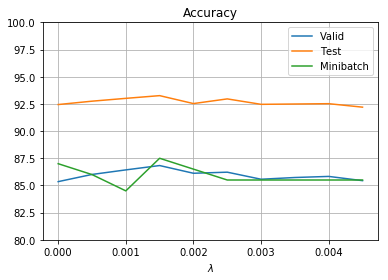

In [54]:
plt.plot(lams,valid_accuracy,label='Valid')
plt.plot(lams,test_accuracy,label='Test')
plt.plot(lams,batch_accuracy,label='Minibatch')
plt.xlabel('$\lambda$')
plt.ylim([80,100])
plt.legend()
plt.grid()
plt.title('Accuracy');